In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Input,Multiply

In [9]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split

In [6]:
def Squuexe_and_attention(x,ratio=8):
    b,_,_,c=x.shape
    x1= GlobalAveragePooling2D()(x)
    d1=Dense(c//ratio,activation="relu", use_bias=False)(x1)
    d2=Dense(c,activation="sigmoid",use_bias=False)(d1)
    ret=Multiply()([x,d2])
    return ret

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=0.2,
        fill_mode='nearest')
batch_size = 32
train_generator = datagen.flow_from_directory(
    '/kaggle/input/ck-dataset',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',   
    subset='training',
    shuffle=True
)
val_generator = datagen.flow_from_directory(
    '/kaggle/input/ck-dataset',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 788 images belonging to 7 classes.
Found 193 images belonging to 7 classes.


In [25]:
from tensorflow.keras.applications import MobileNet

mobile_base = MobileNet(
    input_shape=(150,150, 3),  # Can change to (96, 96, 3) for faster/smaller models
    alpha=0.5,                  # Controls model size (1.0 = full, 0.5 = smaller)
    include_top=False,         # Exclude final classification layer (for custom tasks)
    weights='imagenet'         # Use pretrained ImageNet weights
)
for layer in mobile_base.layers:
    layer.trainable = False

/tmp/ipykernel_36/1334362283.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobile_base = MobileNet(


In [26]:
x=mobile_base.output
x=Squuexe_and_attention(x)
x = Flatten()(x)
x=Dense(256,activation="relu")(x)
x=Dropout(0.3)(x)
x=Dense(128,activation="relu")(x)
output = Dense(7,activation="softmax")(x)

In [27]:

mobile= Model(inputs=mobile_base.input, outputs=output)

In [28]:

mobile.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
movile_his =mobile.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 426ms/step - accuracy: 0.3381 - loss: 2.1975 - val_accuracy: 0.4870 - val_loss: 1.3638
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.5523 - loss: 1.3076 - val_accuracy: 0.5751 - val_loss: 1.1167
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.6059 - loss: 1.1029 - val_accuracy: 0.5907 - val_loss: 1.1581
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.6443 - loss: 1.0102 - val_accuracy: 0.5959 - val_loss: 1.0974
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.7131 - loss: 0.8149 - val_accuracy: 0.6839 - val_loss: 0.9134
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.7022 - loss: 0.8291 - val_accuracy: 0.6114 - val_loss: 1.1438
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.7227 - loss: 0.7630 - val_accuracy: 0.6736 - val_loss: 0.9637
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.6961 - loss: 0.8152 - val_accuracy: 0

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
import tensorflow as tf

def visualize_attention_heatmaps(model, val_generator, num_images=10):
    """
    Generate attention heatmaps for random images from validation generator
    
    Args:
        model: Your trained model with squeeze-and-excitation
        val_generator: Validation data generator
        num_images: Number of random images to visualize
    """
    
    # Create intermediate models to get feature maps
    # Get the layer before squeeze-and-excitation (last conv layer from MobileNet)
    pre_se_output = model.get_layer('conv_pw_13_relu').output  # Last conv layer before SE
    
    # Get the layer after squeeze-and-excitation (multiply_1)
    se_output = model.get_layer('multiply_1').output
    
    # Also get the attention weights from dense_6 (sigmoid output)
    attention_weights = model.get_layer('dense_6').output
    
    # Create intermediate model
    intermediate_model = Model(inputs=model.input, 
                             outputs=[pre_se_output, se_output, attention_weights])
    
    # Get random batch from validation generator
    batch_x, batch_y = next(val_generator)
    
    # Select random images from the batch
    batch_size = batch_x.shape[0]
    selected_indices = np.random.choice(batch_size, min(num_images, batch_size), replace=False)
    
    # Get class names
    class_names = list(val_generator.class_indices.keys())
    
    # Create figure
    fig, axes = plt.subplots(num_images, 4, figsize=(16, 4*num_images))
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    for idx, img_idx in enumerate(selected_indices):
        # Get single image
        img = batch_x[img_idx:img_idx+1]
        true_label = np.argmax(batch_y[img_idx])
        
        # Get predictions
        predictions = model.predict(img, verbose=0)
        predicted_label = np.argmax(predictions[0])
        confidence = np.max(predictions[0])
        
        # Get intermediate features
        features = intermediate_model.predict(img, verbose=0)
        pre_se_features = features[0][0]    # Shape: (H, W, C) - before SE
        post_se_features = features[1][0]   # Shape: (H, W, C) - after SE
        channel_attention = features[2][0]  # Shape: (C,) - SE attention weights
        
        # Create attention map using SE channel weights
        # Method 1: Weight channels by SE attention and average
        weighted_features = pre_se_features * channel_attention
        se_attention_map = np.mean(weighted_features, axis=-1)
        se_attention_map = (se_attention_map - se_attention_map.min()) / (se_attention_map.max() - se_attention_map.min() + 1e-8)
        
        # Method 2: Use the difference between pre and post SE features
        feature_diff = np.mean(post_se_features - pre_se_features, axis=-1)
        feature_diff = (feature_diff - feature_diff.min()) / (feature_diff.max() - feature_diff.min() + 1e-8)
        
        # Method 3: Show which channels are most attended to
        top_channels = np.argsort(channel_attention)[-5:]  # Top 5 channels
        top_channel_map = np.mean(pre_se_features[:, :, top_channels], axis=-1)
        top_channel_map = (top_channel_map - top_channel_map.min()) / (top_channel_map.max() - top_channel_map.min() + 1e-8)
        
        # Resize attention maps to match input image size
        se_attention_resized = cv2.resize(se_attention_map, (150, 150))
        feature_diff_resized = cv2.resize(feature_diff, (150, 150))
        top_channel_resized = cv2.resize(top_channel_map, (150, 150))
        
        # Original image (denormalize for display)
        original_img = img[0]
        if original_img.max() <= 1.0:  # If normalized to [0,1]
            original_img = (original_img * 255).astype(np.uint8)
        else:
            original_img = original_img.astype(np.uint8)
        
        # Plot original image
        axes[idx, 0].imshow(original_img)
        axes[idx, 0].set_title(f'Original\nTrue: {class_names[true_label]}\nPred: {class_names[predicted_label]} ({confidence:.2f})')
        axes[idx, 0].axis('off')
        
        # Plot SE weighted attention heatmap
        im1 = axes[idx, 1].imshow(se_attention_resized, cmap='jet', alpha=0.7)
        axes[idx, 1].set_title('SE Channel Attention\n(Weighted Features)')
        axes[idx, 1].axis('off')
        plt.colorbar(im1, ax=axes[idx, 1], fraction=0.046, pad=0.04)
        
        # Plot feature difference heatmap
        im2 = axes[idx, 2].imshow(feature_diff_resized, cmap='jet', alpha=0.7)
        axes[idx, 2].set_title('Feature Difference\n(Post-Pre SE)')
        axes[idx, 2].axis('off')
        plt.colorbar(im2, ax=axes[idx, 2], fraction=0.046, pad=0.04)
        
        # Plot overlay with SE attention
        axes[idx, 3].imshow(original_img)
        axes[idx, 3].imshow(se_attention_resized, cmap='jet', alpha=0.4)
        axes[idx, 3].set_title('SE Attention Overlay')
        axes[idx, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_grad_cam_attention(model, val_generator, num_images=10, layer_name=None):
    """
    Alternative approach using Grad-CAM for better spatial attention visualization
    """
    
    # Get random batch
    batch_x, batch_y = next(val_generator)
    batch_size = batch_x.shape[0]
    selected_indices = np.random.choice(batch_size, min(num_images, batch_size), replace=False)
    
    # Find the last convolutional layer if layer_name not specified
    if layer_name is None:
        layer_name = 'conv_pw_13_relu'  # Use the last conv layer from your model
    
    # Get class names
    class_names = list(val_generator.class_indices.keys())
    
    # Create figure
    fig, axes = plt.subplots(num_images, 3, figsize=(12, 4*num_images))
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    for idx, img_idx in enumerate(selected_indices):
        img = batch_x[img_idx:img_idx+1]
        true_label = np.argmax(batch_y[img_idx])
        
        # Generate Grad-CAM
        grad_cam = generate_grad_cam(model, img, layer_name, true_label)
        
        # Get prediction
        predictions = model.predict(img, verbose=0)
        predicted_label = np.argmax(predictions[0])
        confidence = np.max(predictions[0])
        
        # Original image
        original_img = img[0]
        if original_img.max() <= 1.0:
            original_img = (original_img * 255).astype(np.uint8)
        else:
            original_img = original_img.astype(np.uint8)
        
        # Plot original
        axes[idx, 0].imshow(original_img)
        axes[idx, 0].set_title(f'Original\nTrue: {class_names[true_label]}\nPred: {class_names[predicted_label]} ({confidence:.2f})')
        axes[idx, 0].axis('off')
        
        # Plot Grad-CAM
        im = axes[idx, 1].imshow(grad_cam, cmap='jet')
        axes[idx, 1].set_title('Grad-CAM Heatmap')
        axes[idx, 1].axis('off')
        plt.colorbar(im, ax=axes[idx, 1], fraction=0.046, pad=0.04)
        
        # Plot overlay
        axes[idx, 2].imshow(original_img)
        axes[idx, 2].imshow(grad_cam, cmap='jet', alpha=0.4)
        axes[idx, 2].set_title('Grad-CAM Overlay')
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

def generate_grad_cam(model, img, layer_name, class_index):
    """Generate Grad-CAM heatmap"""
    
    # Create a model that maps the input image to the activations of the target layer
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    
    # Compute the gradient of the top predicted class for our input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, class_index]
    
    # Extract the gradients of the last conv layer with respect to the loss
    grads = tape.gradient(loss, conv_outputs)
    
    # Pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight the channels by the corresponding gradients and sum up
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    
    # Resize to input image size
    heatmap = cv2.resize(heatmap, (150, 150))
    
    return heatmap

# Usage example:
# visualize_attention_heatmaps(mobile, val_generator, num_images=10)
# or for Grad-CAM approach:
# visualize_grad_cam_attention(mobile, val_generator, num_images=10)

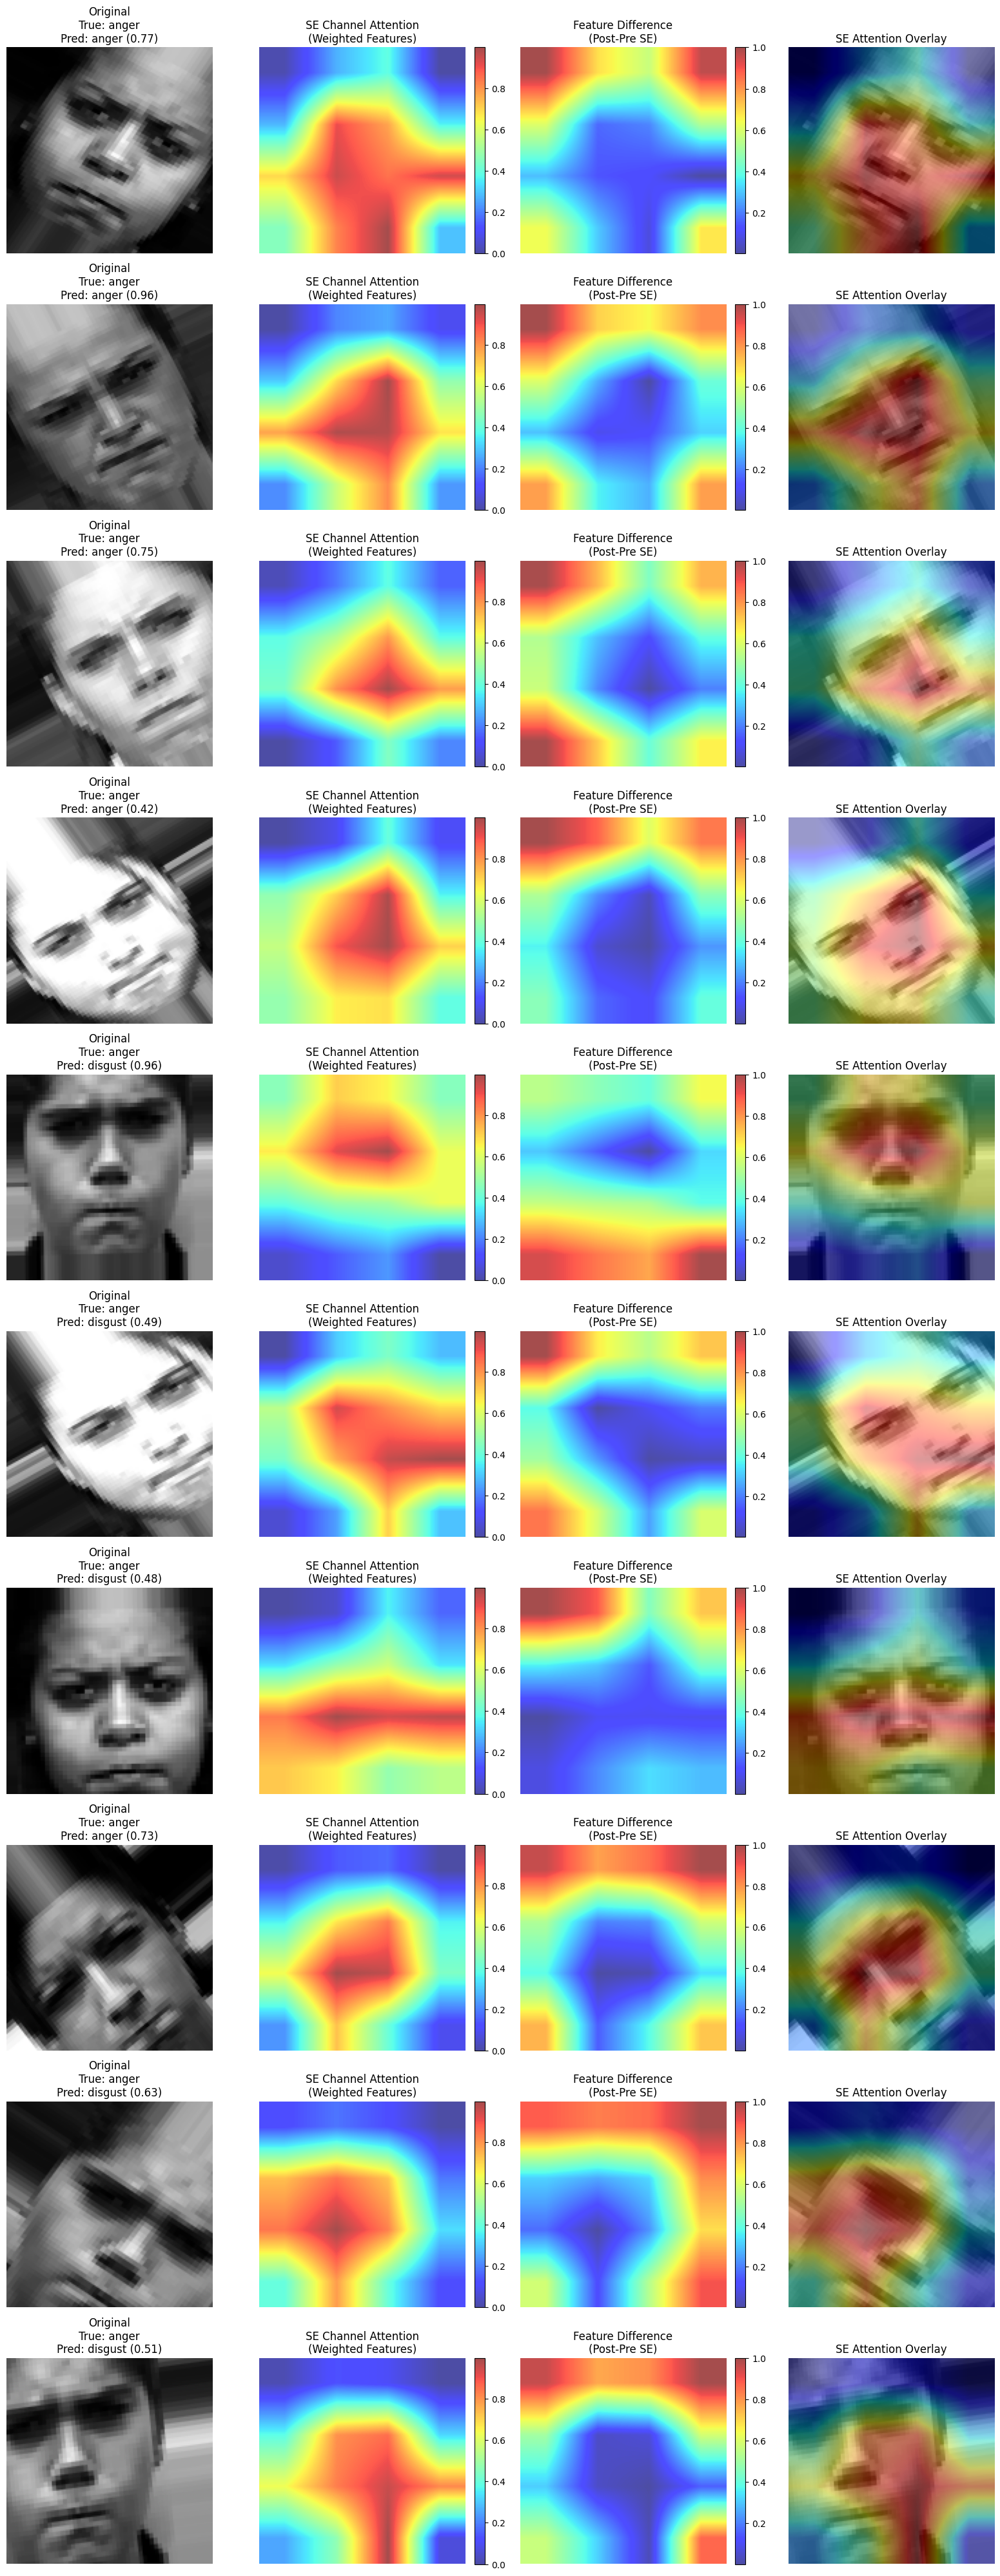

In [38]:
visualize_attention_heatmaps(mobile, val_generator, num_images=10)